In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import textwrap
from datetime import datetime

## Recent AK COVID-19 data
- https://coronavirus-response-alaska-dhss.hub.arcgis.com/datasets/table-3-demographic-distribution-of-confirmed-cases/geoservice

In [2]:
query_url = ("https://services1.arcgis.com/"
             "WzFsmainVTuD5KML/arcgis/rest/services/"
             "Demographic_Distribution_of_Confirmed_Cases/"
             "FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json")

retrieval_date = datetime.now()

In [3]:
r = requests.get(query_url)
case_data = pd.json_normalize(r.json(), record_path='features')

case_data.columns = case_data.columns.str.lstrip('attributes.')
case_data.columns = case_data.columns.str.replace('_',' ')
# case_data.columns = case_data.columns.str.lower()
case_data = case_data.drop(columns=['ObjectId'])
case_data = case_data.set_index('Demographic')
case_data.index.name = None

# convert percentage strings to floats
percent_columns = case_data.filter(regex='Percentage').columns
for percent_column in percent_columns:
    case_data[percent_column] = case_data[percent_column].str.rstrip('%').astype('float')

    
# rename columns
case_data = case_data.rename(
    index={
        'AI/AN':'American Indian and Alaska Native',
        'NHOPI':'Native Hawaiian and Other Pacific Islander',
        'Black':'Black or African American',
        'Multiple': 'Multiple Races',
        'Other': 'Other Race',
        'UI Race': 'Race Under Investigation',
        'Hispanic': 'Hispanic Ethnicity',
        'Non-Hispanic': 'Non-Hispanic Ethnicity',
        'UI Ethnicity': 'Ethnicity Under Investigation',
    })


In [4]:
case_data

,All Cases,All Cases Percentage,Community Cases,Community Cases Percentage,Secondary Cases,Secondary Cases Percentage,Travel Cases,Travel Cases Percentage,UI Cases,UI Cases Percentage,Hospitalizations,Hospitalizations Percentage,Deaths,Deaths Percentage
Male,26301,52.0,835,51.9,1042,51.5,221,53.5,23846,52.0,637,55.9,141,61.6
Female,24263,48.0,774,48.1,982,48.5,192,46.5,21999,48.0,501,44.0,88,38.4
Unknown Sex,8,0.0,0,0.0,0,0.0,0,0.0,8,0.0,1,0.1,0,0.0
<10 Years,3270,6.5,35,2.2,141,7.0,14,3.4,3056,6.7,11,1.0,0,0.0
10-19 Years,6022,11.9,136,8.5,247,12.2,60,14.5,5508,12.0,8,0.7,0,0.0
20-29 Years,10501,20.8,429,26.7,497,24.6,67,16.2,9368,20.4,52,4.6,3,1.3
30-39 Years,9658,19.1,286,17.8,356,17.6,81,19.6,8808,19.2,89,7.8,6,2.6
40-49 Years,7006,13.9,237,14.7,251,12.4,65,15.7,6370,13.9,105,9.2,8,3.5
50-59 Years,6530,12.9,202,12.6,257,12.7,54,13.1,5939,13.0,190,16.7,18,7.9
60-69 Years,4669,9.2,169,10.5,143,7.1,47,11.4,4219,9.2,252,22.1,42,18.3


## Population estimates from US Census
- https://data.census.gov/cedsci/table?q=race&g=0400000US02&d=ACS%201-Year%20Estimates%20Detailed%20Tables&tid=ACSDT1Y2019.C02003&hidePreview=true

In [5]:
pop_est = pd.read_csv('../resources/ACSDT1Y2019.C02003-2021-01-16T203459.csv',
                      thousands=',', index_col="Label")
pop_est.index = pop_est.index.str.lstrip()

# rename columns
pop_est = pop_est.rename(
    index={
        'Population of two or more races:': 'Multiple Races',
        'Some other race': 'Other Race',
    })

# rename columns
pop_est = pop_est.rename(
    columns={
        'Alaska!!Estimate': 'Population Estimate',
        'Alaska!!Margin of Error': 'Error Margin',
    })

pop_est = pop_est.drop(columns=['Error Margin'])

pop_est.index.name = None

In [6]:
pop_est/pop_est['Population Estimate'].loc['Total:'] * 100

,Population Estimate
Total:,100.000000
Population of one race:,92.143204
White,64.216282
Black or African American,3.082654
American Indian and Alaska Native,15.794517
Asian,5.970651
Native Hawaiian and Other Pacific Islander,1.356444
Other Race,1.722655
Multiple Races,7.856796
Two races including Some other race,0.354182


In [7]:
include_list = [
    'American Indian and Alaska Native',
    'Asian',
    'Black or African American',
    'Native Hawaiian and Other Pacific Islander',
    'White',
    'Other Race',
    'Multiple Races'
]

other_includes = [
    'Unknown Race',
    'Race Under Investigation'
]

In [8]:
race_pop_data = case_data.loc[include_list+other_includes].merge(pop_est.loc[include_list],
                                                 left_index=True, right_index=True, how='left')

In [9]:
race_pop_data

,All Cases,All Cases Percentage,Community Cases,Community Cases Percentage,Secondary Cases,Secondary Cases Percentage,Travel Cases,Travel Cases Percentage,UI Cases,UI Cases Percentage,Hospitalizations,Hospitalizations Percentage,Deaths,Deaths Percentage,Population Estimate
American Indian and Alaska Native,10815,21.4,437,27.2,501,24.8,51,12.3,9721,21.2,304,26.7,90,39.3,115544.0
Asian,2019,4.0,78,4.8,101,5.0,19,4.6,1799,3.9,109,9.6,23,10.0,43678.0
Black or African American,1286,2.5,93,5.8,116,5.7,21,5.1,1042,2.3,45,4.0,9,3.9,22551.0
Native Hawaiian and Other Pacific Islander,1395,2.8,76,4.7,139,6.9,4,1.0,1171,2.6,121,10.6,16,7.0,9923.0
White,15795,31.2,716,44.5,856,42.3,253,61.3,13801,30.1,372,32.7,87,38.0,469771.0
Other Race,6370,12.6,42,2.6,55,2.7,16,3.9,6133,13.4,47,4.1,0,0.0,12602.0
Multiple Races,3983,7.9,73,4.5,93,4.6,13,3.1,3774,8.2,69,6.1,2,0.9,57476.0
Unknown Race,497,1.0,94,5.8,163,8.1,36,8.7,0,0.0,9,0.8,1,0.4,NaN
Race Under Investigation,8412,16.6,0,0.0,0,0.0,0,0.0,8412,18.3,63,5.5,1,0.4,NaN


In [10]:
rate_data = race_pop_data[['All Cases', 'Hospitalizations', 'Deaths']].div(race_pop_data['Population Estimate'], axis=0)

rate_data = rate_data.rename(columns={
    "All Cases": "Case Rate",
    "Hospitalizations": "Hospitalization Rate",
    "Deaths": "Death Rate"
})

In [11]:
rate_data

,Case Rate,Hospitalization Rate,Death Rate
American Indian and Alaska Native,0.093601,0.002631,0.000779
Asian,0.046225,0.002496,0.000527
Black or African American,0.057026,0.001995,0.000399
Native Hawaiian and Other Pacific Islander,0.140582,0.012194,0.001612
White,0.033623,0.000792,0.000185
Other Race,0.505475,0.003730,0.000000
Multiple Races,0.069298,0.001201,0.000035
Unknown Race,NaN,NaN,NaN
Race Under Investigation,NaN,NaN,NaN


In [12]:
def save_png(figure, png_path):
    
    print(f'Saving PNG {png_path}')
    figure.savefig(png_path, bbox_inches='tight', pad_inches=0.3, dpi=72, facecolor='w')
    plt.close(figure) # comment out if you want outputs on the screen

## Infection, hospitalization, and deaths for each population

In [13]:
def count_plot(
    _series,
    color = '#006B95',
    title = '',
    width = 0.8
):
    
    # categories
    x_labels = _series.index
    x_labels = ['\n'.join(textwrap.wrap(label, 18)) for label in x_labels]
    x_locs = np.arange(len(x_labels))  # the label locations    
    # y-values
    y_values = _series.values
    
    fig = plt.figure(figsize=(22,9))
    ax = fig.add_axes([0,0,1,1])
    
    rects1 = ax.bar(x_locs, y_values, width, color=color)

#    xlabels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in xlabels]
    ax.set_xticks(np.arange(len(x_locs)))
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_ylabel('Count', fontsize=16, labelpad=12)
    # grid
#     ax.grid(axis='y')
#     ax.set_axisbelow(True)
#     ax.yaxis.grid(color='lightgray', linestyle='dashed')

    # Hide stuff
#     ax.yaxis.label.set_visible(False)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(2)

    # Tick size
    ax.tick_params(axis='x', labelsize=16, length=0)
    ax.tick_params(axis='x', pad=10)
    
    ax.tick_params(axis='y', labelsize=16, length=10)

    ax.set_title(title, fontsize=30, fontweight='bold', loc='left', pad=30)
    ax.text(0, 1.015,
            'Data retrieved on ' + retrieval_date.strftime("%b %d, %Y at %-I:%M %p"),
            transform=ax.transAxes,
           fontsize=14, color='#555555')
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:0.0f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 20),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='top',
                        fontsize=18,
                        fontweight='bold',
                        color='#000000'
                       )
    autolabel(rects1)

    return fig

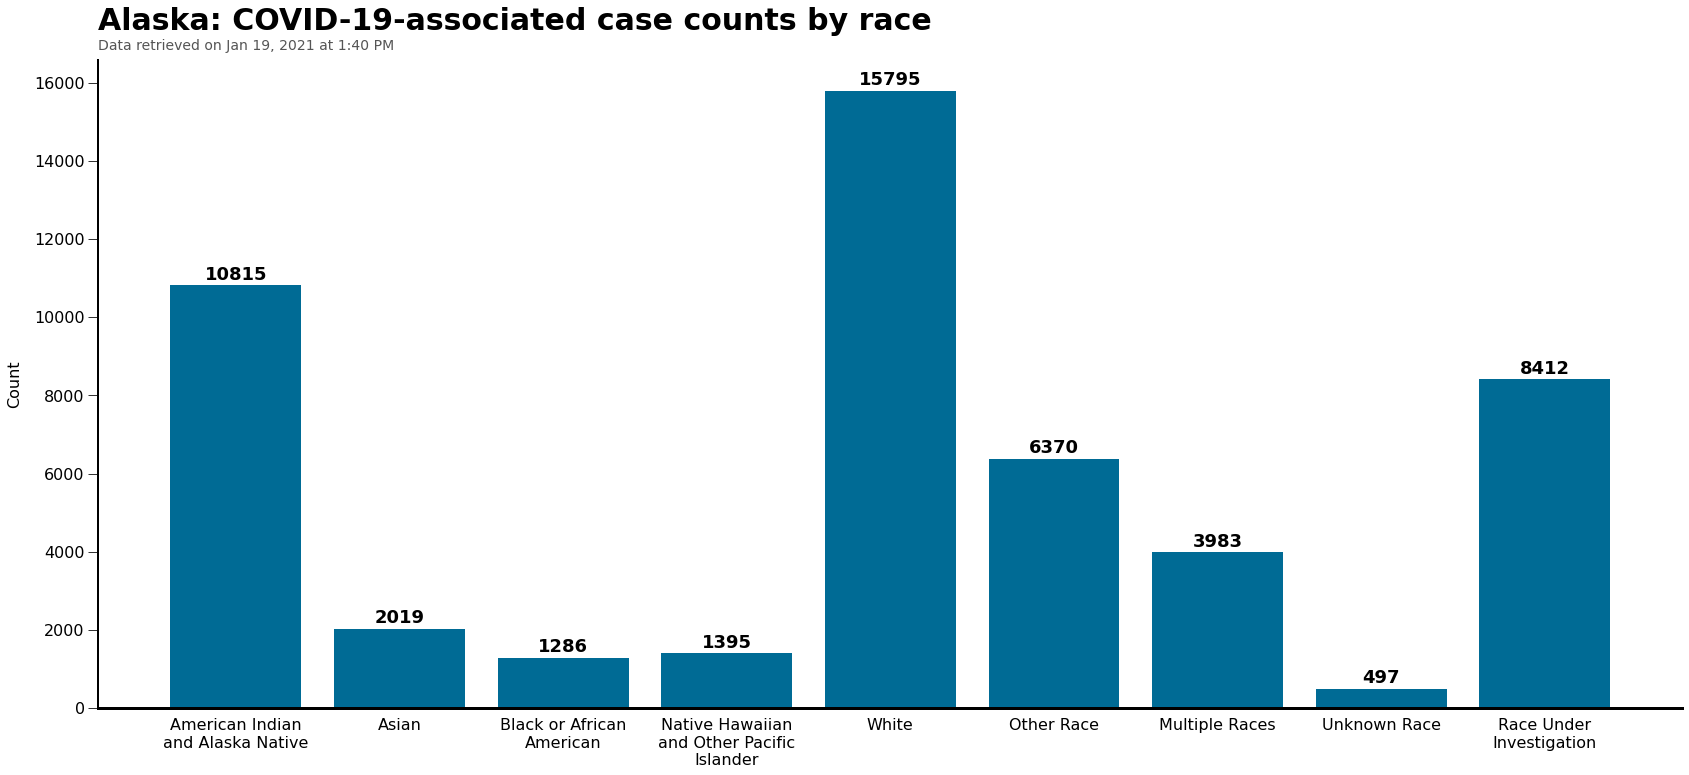

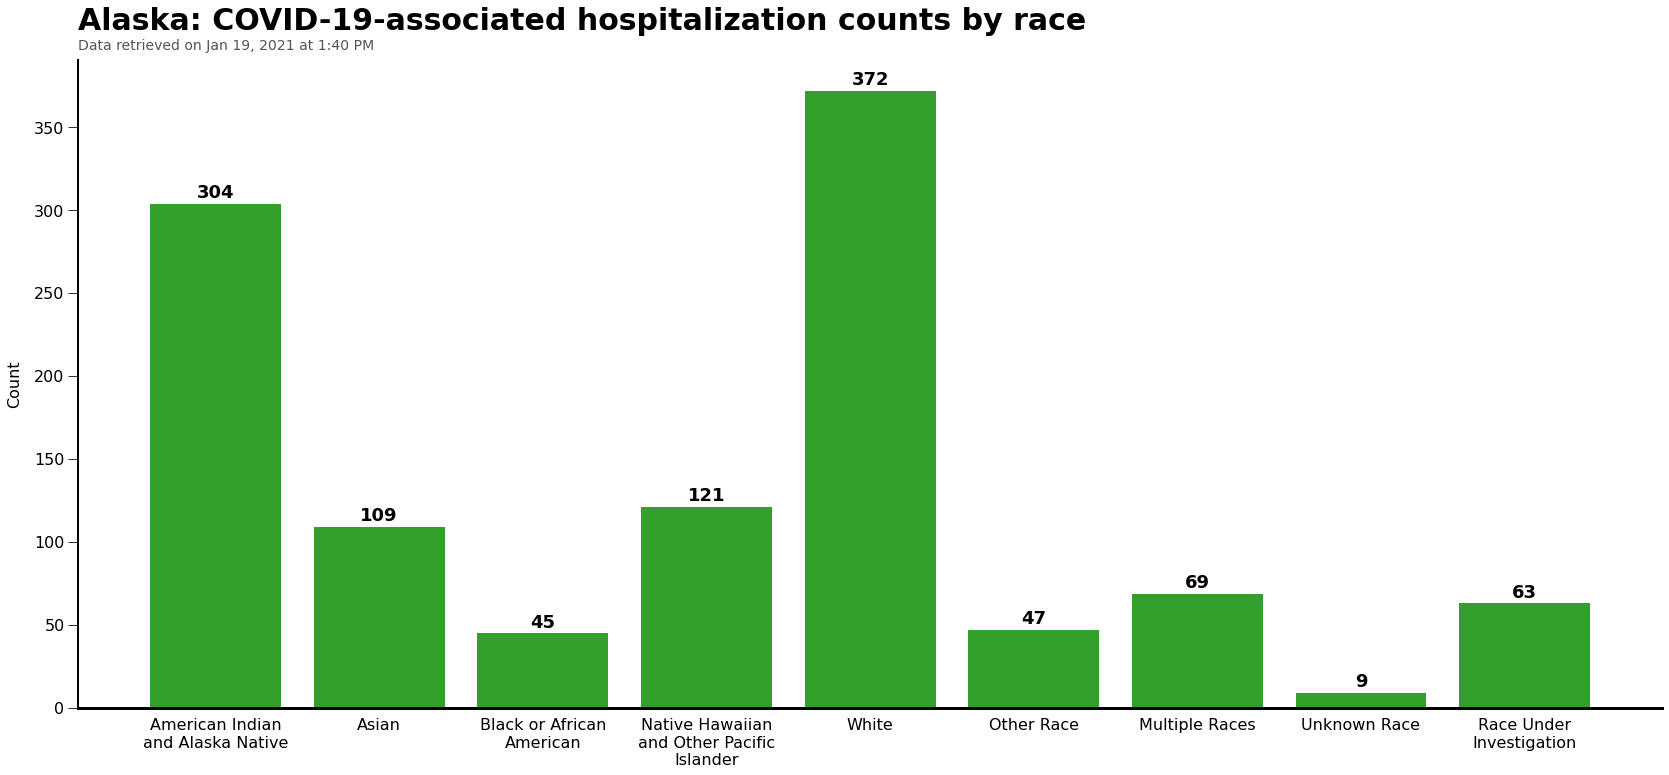

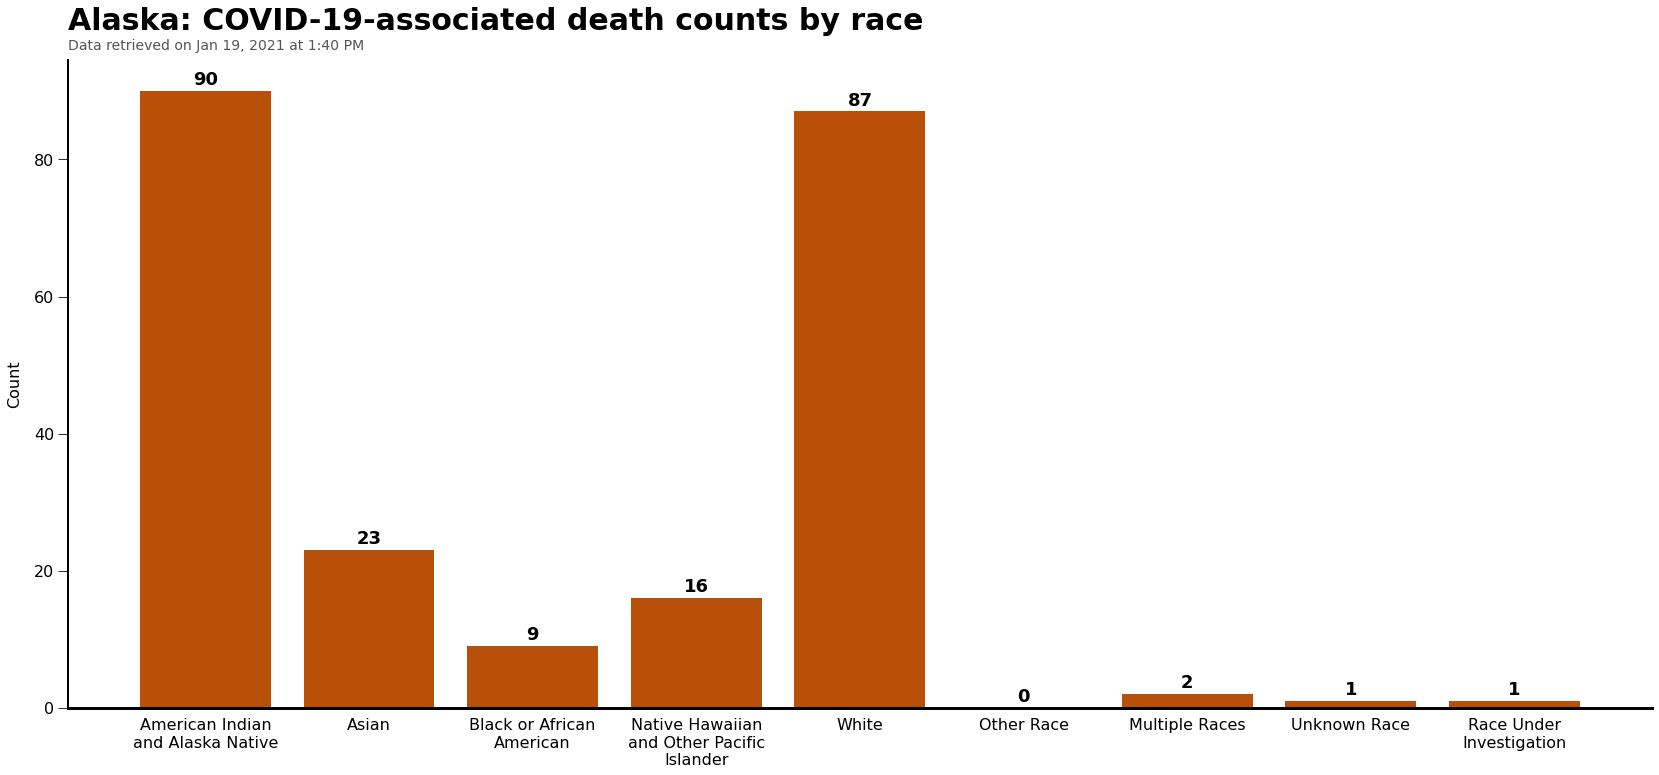

In [14]:
case_count_plot = count_plot(race_pop_data['All Cases'], title='Alaska: COVID-19-associated case counts by race')
hosp_count_plot = count_plot(race_pop_data['Hospitalizations'], title='Alaska: COVID-19-associated hospitalization counts by race', color='#33a02c')
deat_count_plot = count_plot(race_pop_data['Deaths'], title='Alaska: COVID-19-associated death counts by race', color='#B85009')

In [15]:
save_png(case_count_plot, f"../outputs/{retrieval_date.strftime('%Y%m%d')}-case-count-by-race.png")
save_png(hosp_count_plot, f"../outputs/{retrieval_date.strftime('%Y%m%d')}-hospitalization-count-by-race.png")
save_png(deat_count_plot, f"../outputs/{retrieval_date.strftime('%Y%m%d')}-death-count-by-race.png")

Saving PNG ../outputs/20210119-case-count-by-race.png
Saving PNG ../outputs/20210119-hospitalization-count-by-race.png
Saving PNG ../outputs/20210119-death-count-by-race.png


In [16]:
def rate_plot(
    _series,
    color = '#006B95',
    title = '',
    width = 0.8
):
    
    # categories
    x_labels = _series.index
    x_labels = ['\n'.join(textwrap.wrap(label, 18)) for label in x_labels]
    x_locs = np.arange(len(x_labels))  # the label locations    
    # y-values
    y_values = _series.values * 100000
    
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_axes([0,0,1,1])
    
    rects1 = ax.bar(x_locs, y_values, width, color=color)

#    xlabels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in xlabels]
    ax.set_xticks(np.arange(len(x_locs)))
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_ylabel('Rate per 100,000 population', fontsize=16, labelpad=12)
    # grid
#     ax.grid(axis='y')
#     ax.set_axisbelow(True)
#     ax.yaxis.grid(color='lightgray', linestyle='dashed')

    # Hide stuff
#     ax.yaxis.label.set_visible(False)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(2)

    # Tick size
    ax.tick_params(axis='x', labelsize=16, length=0)
    ax.tick_params(axis='x', pad=10)
    
    ax.tick_params(axis='y', labelsize=16, length=10)

    ax.set_title(title, fontsize=30, fontweight='bold', loc='left', pad=30)
    ax.text(0, 1.015,
            ('Cases listed as "Unknown Race" or "Race Under Investigation" not included. '
            'Data retrieved on ' + retrieval_date.strftime("%b %d, %Y at %-I:%M %p") + '.'),
            transform=ax.transAxes,
           fontsize=14, color='#555555')
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:0.0f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 20),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='top',
                        fontsize=18,
                        fontweight='bold',
                        color='#000000'
                       )
    autolabel(rects1)

    return fig

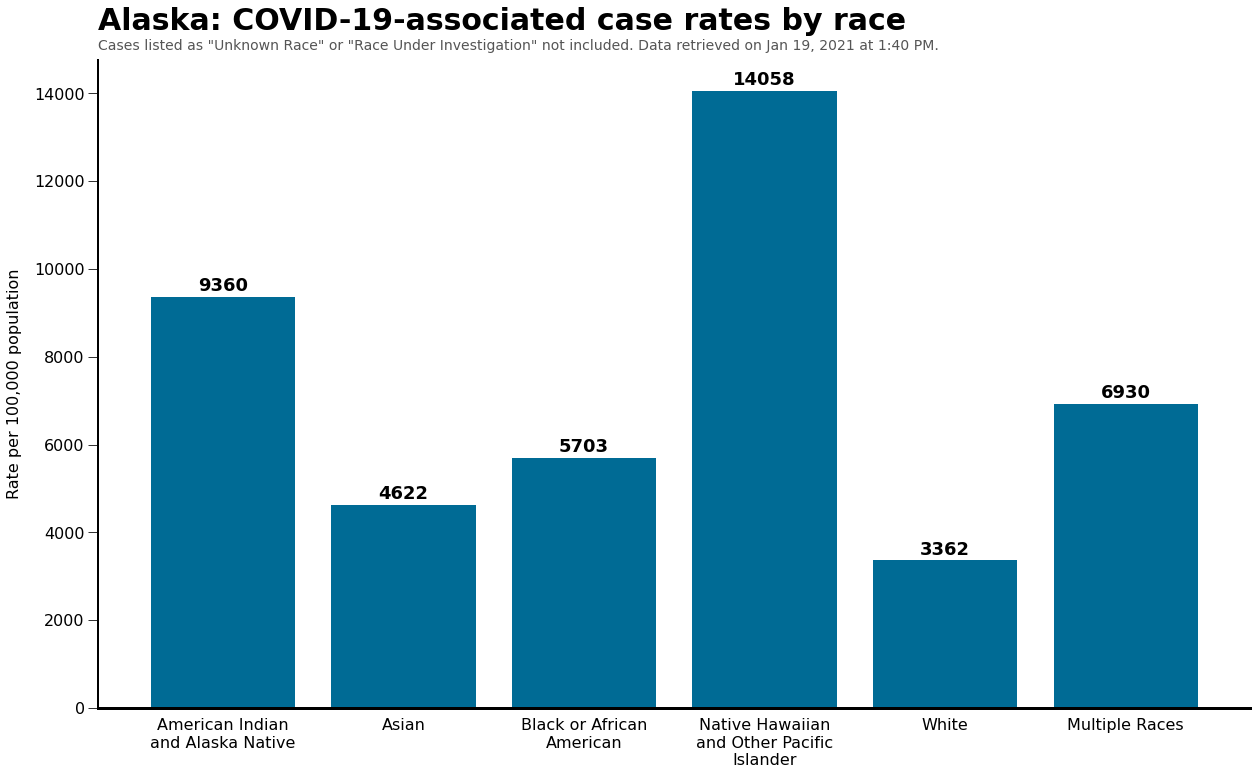

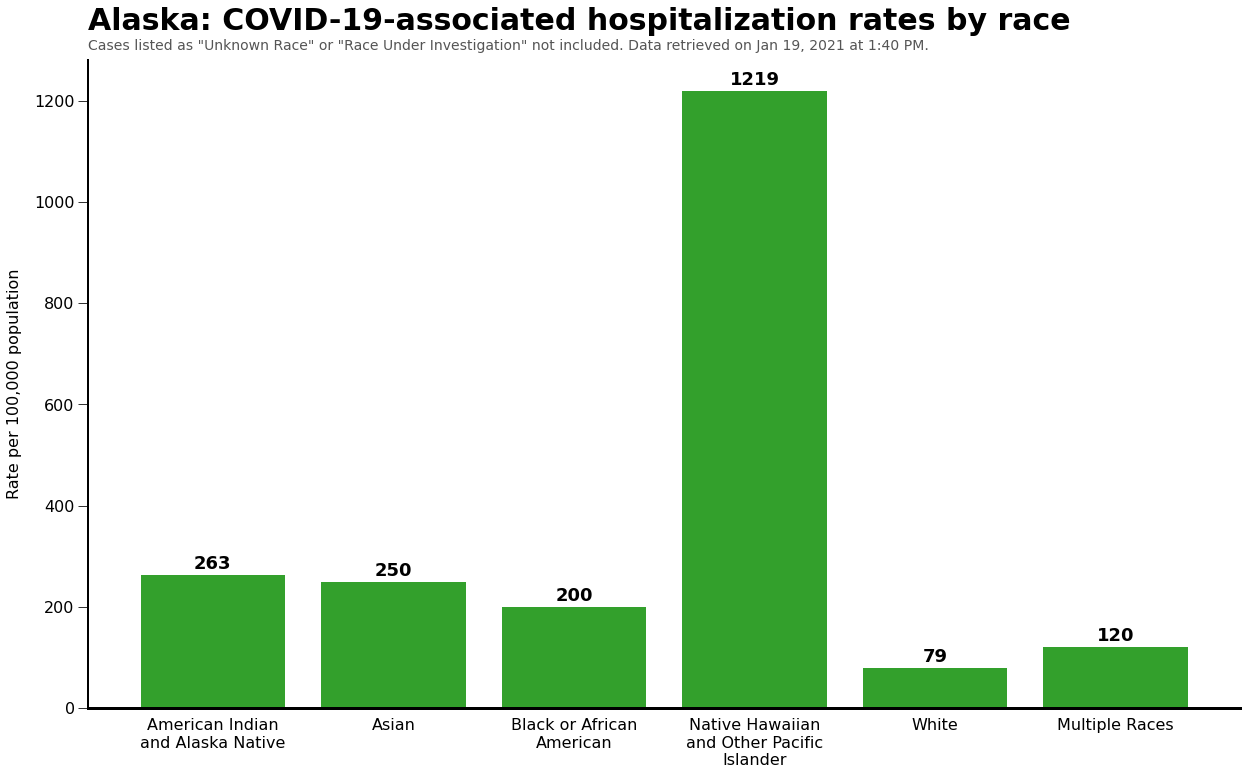

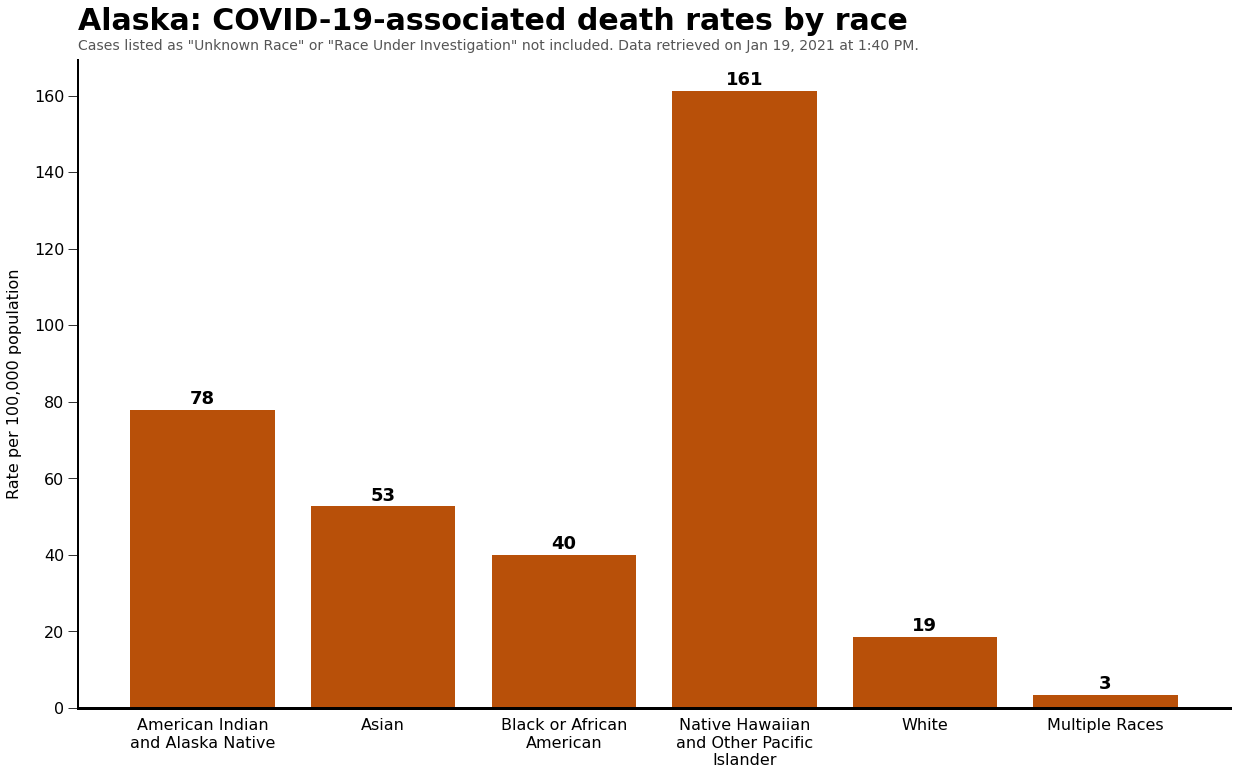

In [17]:
to_plot = rate_data.drop(labels=['Other Race', 'Unknown Race', 'Race Under Investigation'])

case_rate_plot = rate_plot(to_plot['Case Rate'], title='Alaska: COVID-19-associated case rates by race')
hosp_rate_plot = rate_plot(to_plot['Hospitalization Rate'], title='Alaska: COVID-19-associated hospitalization rates by race', color='#33a02c')
deat_rate_plot = rate_plot(to_plot['Death Rate'], title='Alaska: COVID-19-associated death rates by race', color='#B85009')

In [18]:
save_png(case_rate_plot, f"../outputs/{retrieval_date.strftime('%Y%m%d')}-case-rate-by-race.png")
save_png(hosp_rate_plot, f"../outputs/{retrieval_date.strftime('%Y%m%d')}-hospitalization-rate-by-race.png")
save_png(deat_rate_plot, f"../outputs/{retrieval_date.strftime('%Y%m%d')}-death-rate-by-race.png")

Saving PNG ../outputs/20210119-case-rate-by-race.png
Saving PNG ../outputs/20210119-hospitalization-rate-by-race.png
Saving PNG ../outputs/20210119-death-rate-by-race.png
